# **Downloads**
Install fasttext, get language predictor and download Wikimatrix data

In [8]:
!pip install fasttext
!wget "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz"
!wget https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-hr.tsv.gz

In [2]:
#Imports
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import lzma
import gzip
import fasttext
import csv
import unicodedata
import re
import time
import spacy

# **Functions**

Quality tests for sentences

In [3]:
def preprocess(text):
    text = re.sub(r'\r\n|\r|\n|\\n', ' ', text) #Eliminate \n
    text = text.lower()
    return unicodedata.normalize("NFKD", text) # Standarize spaces, etc

def toosimilar(t1,t2, threshold=0.5):
    '''Compares if frantion of tokens in t1 present in t2 is higher than threshold'''
    matches = sum([t in t2 for t in t1.split()])
    return matches/len(t1.split())>threshold
 

def langdetect(t1,t2, lang1, lang2):
    '''Check if sentence 1 is in language 1 and sentence 2 in language 2'''
    return all([LangDetect.predict(t1)[0][0][-2:] == lang1,LangDetect.predict(t2)[0][0][-2:] == lang2])

def conditionsENG(word):
    '''English words should only contain [a-z]. Check if true'''
    regex = r"([a-z])+" #"|[âçèéêîôû])+" 
    match = re.match(regex, word.lower())
    if match is None: 
        return False
    match= match.group(0)
    return word == match

def AnyMultiples(text):
    '''Row structure is: Score \TAB SentenceENG \TAB SentenceLANG2 \TAB 
    Some rows are, however: Score   SentenceENG   SentenceLANG2  Score   SentenceENG   SentenceLANG2  ... 
    So x3 \SPACE instead of \TAB, which confuses the tsv_reader. We skip these rows, since we already have a whole lot of examples'''
    regex = r'[0-9]{8}'
    match = re.match(regex, text)
    if match is None: 
        return False
    return True

def LanguageIsCorrect(t1,t2, lang1, lang2):
    return not toosimilar(t1, t2) and langdetect(t1,t2, lang1, lang2)

def UpdateDict(dic, t1, t2):
    '''1) Process with spacy; 2) Check if token is not ENG of if it's present in translation; 3) Lemmatize and update dictionay;
    Returns: dic: updated dictionary dic; lemmatized English sentence'''
    for doc in nlp.pipe([t1], batch_size=3000, n_process=1, disable=["parser", "ner"]): #lemmatizer
        for word in doc:
            if conditionsENG(str(word)) == False: continue
            if str(word) in t2.split(): continue

            lemma = word.lemma_
            if lemma not in en_words: continue
            if lemma in dic.keys():
                dic[lemma] += 1
            else: dic[lemma] = 1
    return dic, ' '.join([x.lemma_ for x in doc])

 
def SaveVar(data, file):
    '''Save variable data to file. For example, goodpairs to "Sentences_Freqs02-09_ScoreOver1.04_en-hr.txt" '''
    with open(file, 'w') as f:
        print(data, file=f)


In [4]:
# Load English dictionary
with open('en_words.txt') as f:
    en_words = []
    for line in f:
      en_words.append(line[:-1])
    f.close()

LangDetect = fasttext.load_model('lid.176.ftz') # Language Predictor
nlp  = spacy.load("en_core_web_sm") # Lemmatizer

In [6]:
# Define Wiktionary languages
WikiMatrix = 'WikiMatrix.en-hr.tsv.gz'
LANG = 'hr'
lang1, lang2 = lang1, lang2 = sorted([LANG, 'en'])

# **Create dictionary of lemmas**

Go through all rows in tsv Wikimatrix file with Score > 1.04, perform quality tests for sentences.
The good sentences get lemmatized and their lemmas get stored in dictionary dic with a counter of occurences
The lemmatized sentences are stored in list sentence_lemmas. This avoids double lemmatization in posterior steps and saves much time, since this is the most time-consuming step.

In [8]:
 sentence_lemmas = []
dic = {}
start_time = time.time()
threshold = 1e36

with gzip.open(WikiMatrix, 'rt') as f:

    tsv_reader = csv.reader(f, delimiter="\t")
    number_of_lines = int(1e6)
    i,j = -1,0
    
    for row in tsv_reader:
        if float(row[0]) < 1.04: break
        
        #Print progress
        if i%10000 == 0:
            print("Encoding of "+ str(j/1000000)+ " mill out of "+ str(i/1000000)+
                  " mill sentences done after {:.2f} sec. ".format(time.time() - start_time),"Score: {:.2f}".format(float(row[0])))
        
        i+=1
        #Quicktests for skipping unvaluable rows
        if len(row)<3: continue #Skip untranslated
        if len(row[1])>400: continue #Skip too long
        if AnyMultiples(row[1]): continue #Skip wrongly parsed
        
         
        row[1:] = [preprocess(text) for text in row[1:]] #Preprocess sentences

        #Append to dics
        if  LanguageIsCorrect(row[1], row[2], lang1, lang2):
            dic, row_lemma = UpdateDict(dic, row[1],row[2])
            sentence_lemmas.append(row_lemma)
            j+=1

        else: sentence_lemmas.append(None)  
              
print("Encoding of "+ str(j/1000000)+ " mill out of "+ str(i/1000000)+
                  " mill sentences done after {:.2f} sec".format(time.time() - start_time)) 
# Sort by frequency
dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))      

In [ ]:
# Save sentence_lemmas to file
var, file = sentence_lemmas, 'sentence_lemmas_{}-{}.txt'.format(lang1,lang2)
SaveVar(var, file)

# Save dic to file
var, file = dic, 'dict_lemmas_{}-{}.txt'.format(lang1,lang2)
SaveVar(var, file)

# **Statistical analysis**


15623

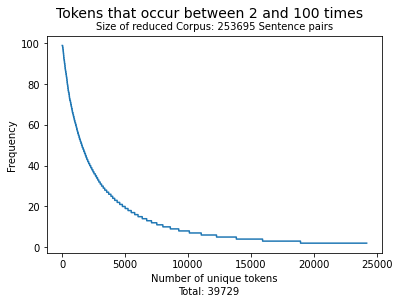

In [ ]:
def PlotFreq(dic, n = None, m=9):
    diclist = list(dic.values())
    index9 = 0
    if n!= None:
        x =[i for i in diclist if i>n and i<m]
    else: x = dictlist
    
    #y = list(dic.keys())[:len(x)]
    plt.plot(x);
    plt.xlabel('Number of unique tokens')
    plt.ylabel('Frequency')
    plt.suptitle('Tokens that occur between %d and 100 times' %(n+1), size=14)
    plt.title('Size of reduced Corpus: %d Sentence pairs' %threshold, size=10)
    plt.figtext(0.5, -0.02, "Total: %d" %len(diclist), ha="center", fontsize=10)

PlotFreq(dic,2,100)

In [ ]:
def Create_dic_red(dic,n=2,m=9):
  '''Reduce dictionary to lemmas with frequencies between n and m. Default: from 2 to 9'''
  dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True)) # Sort in descending order of frequencies
  index2 = diclist.index(n)-1
  index9 = diclist.index(m)
  return list(dic.keys())[index9:index2]


# Reduce dictionary 
dic_red = Create_dic_red(dic)

#**Extract good examples**

In [ ]:
def ExtractSenteces(t1,t2):
  '''Inputs: lemmatized ENG sentence; LANG2 sentence
    Go through lemmas in t1 and 1) Check if lemma is ENG or is present in LANG2 sentence; 
    2) Check if there is already one example for the lemma (dic_check)
    3) Check if lemma is in reduced dictionary. 
    4) If so, add to dic_check and extract sentence appending it to list goodpairs. 
    Add lemma as new row'''
  added = False
  for lemma in t1.split(' '):
    if conditionsENG(lemma) == False: continue # skip non-english
    if lemma in t2.split(): continue # skip untranslated
    if lemma in dic_check: continue # skip words for which we already have one sentence
    
    if lemma in dic_red:
      #print('added!')
      dic_check.add(lemma) # Add to checking list
      if added==False: goodpairs.append(row+[lemma]) # Add sentece to goodpairs with found lemma in new column
      if added==True: goodpairs[-1]+=[lemma] # Add in new column to the already added goodpairs sentence
      added = True
    else: continue

dic_check = {''}
goodpairs = []
start_time = time.time()
allowprint = True

with gzip.open(WikiMatrix, 'rt') as f:

    tsv_reader = csv.reader(f, delimiter="\t")
    i,j = -1,0
    
    for row in tsv_reader:
        if score<1.04: break
        
        #Print progress
        if i%10000 == 0:
            print("Encoding of "+ str(j)+ " out of "+ str(i)+
            " sentences done after {:.2f} sec. ".format(time.time() - start_time),"Score: {:.2f}".format(float(row[0])))
        
        i+=1
        #Quicktests for skipping unvaluable rows
        if type(lemmas) is not str: continue #Skip non-matched
        if len(row)<3: continue #Skip untranslated
        if len(row[1])>400: continue #Skip too long
        if AnyMultiples(row[1]): continue
        
        else: ExtractSenteces(lemmas, row[2]); j+=1 

        if len(goodpairs) % 100 == 0 and len(goodpairs)>0 and allowprint: 
          print(len(goodpairs),'/', len(dic_red))
          allowprint = False
        if len(goodpairs) % 101 == 0: allowprint = True
        
            
print("Encoding of "+ str(j/1000000)+ " mill out of "+ str(i/1000000)+
                  " mill sentences done after {:.2f} sec".format(time.time() - start_time))   

Encoding of 1 out of 0 sentences done after 0.00 sec.  Score: 1.23
100 / 15623
200 / 15623
300 / 15623
400 / 15623
500 / 15623
600 / 15623
700 / 15623
800 / 15623
900 / 15623
1000 / 15623
1100 / 15623
Encoding of 6622 out of 10000 sentences done after 34.14 sec.  Score: 1.10
1200 / 15623
1300 / 15623
1400 / 15623
1500 / 15623
1600 / 15623
1700 / 15623
1800 / 15623
1900 / 15623
2000 / 15623
2100 / 15623
2200 / 15623
2300 / 15623
2400 / 15623
2500 / 15623
2600 / 15623
Encoding of 13392 out of 20000 sentences done after 75.64 sec.  Score: 1.09
2700 / 15623
2800 / 15623
2900 / 15623
3000 / 15623
3100 / 15623
3200 / 15623
3300 / 15623
3400 / 15623
3500 / 15623
3600 / 15623
3700 / 15623
3800 / 15623
3900 / 15623
4000 / 15623
Encoding of 20338 out of 30000 sentences done after 120.71 sec.  Score: 1.09
4100 / 15623
4200 / 15623
4300 / 15623
4400 / 15623
4500 / 15623
4600 / 15623
4700 / 15623
4800 / 15623
4900 / 15623
5000 / 15623
5100 / 15623
5200 / 15623
5300 / 15623
5400 / 15623
Encoding of 

IndexError: ignored

In [ ]:
# Check how many examples and lemmas are included
def ShowHowManyGoodpairs(goodpairs):
    A = pd.DataFrame(goodpairs)
    print(sum(len(np.where(A[A.columns[i]].values != None)[0]) for i in range(3,len(A.columns))), 'lemmas in ', len(goodpairs), 'sentences')

ShowHowManyGoodpairs(goodpairs)

In [ ]:
# Save sentences to file
var, file = goodpairs, 'Good_Sentences_{}-{}.txt'.format(lang1,lang2)
SaveVar(var, file)
